In [4]:
import warnings
warnings.filterwarnings('ignore')

import numpy
import matplotlib.pyplot as plt
import glob

import pandas as pd
#from bokeh.charts import TimeSeries, show, output_file

import iris
from iris.experimental.equalise_cubes import equalise_attributes

## Read data

In [35]:
# Configuration
model = 'NorESM1-M'
experiment = 'historical'
rip = 'r1i1p1'
ua6_dir = '/g/data/ua6/DRSv3/CMIP5'  # /g/data/r87/dbi599
r87_dir = '/g/data/r87/dbi599/DRSv2/CMIP5'

depth_index = 0
i_index = 34
j_index = 50

#lev_constraint = iris.Constraint(lev=depth)
#lat_constraint = iris.Constraint(lat=latitude)
#lon_constraint = iris.Constraint(lon=longitude)

In [56]:
control_files = glob.glob('%s/%s/piControl/mon/ocean/r1i1p1/thetao/latest/thetao_Omon_%s_piControl_r1i1p1_*.nc' %(ua6_dir, model, model) )
experiment_files = glob.glob('%s/%s/%s/mon/ocean/%s/thetao/latest/thetao_Omon_%s_%s_%s_*.nc' %(ua6_dir, model, experiment, rip, model, experiment, rip) )
dedrifted_files = glob.glob('%s/%s/%s/yr/ocean/%s/thetao/latest/dedrifted/thetao_Oyr_%s_%s_%s_??????-??????.nc' %(r87_dir, model, experiment, rip, model, experiment, rip) )
coefficient_file = '%s/%s/piControl/yr/ocean/r1i1p1/thetao/latest/thetao-coefficients_Oyr_%s_piControl_r1i1p1_all.nc' %(r87_dir, model, model)

In [43]:
def read_files(file_list, depth_index, i_index, j_index):
    """Read a list of files into an iris Cube"""
    
    cube = iris.load(file_list, 'sea_water_potential_temperature')
    iris.util.unify_time_units(cube)
    equalise_attributes(cube)
    cube = cube.concatenate_cube()[:, depth_index, i_index, j_index]
    
    return cube

In [44]:
control_cube = read_files(control_files, depth_index, i_index, j_index)

In [46]:
historical_cube = read_files(experiment_files, depth_index, i_index, j_index)

In [52]:
dedrifted_cube = read_files(dedrifted_files, depth_index, i_index, j_index)

In [65]:
a_cube = iris.load_cube(coefficient_file, 'coefficient a')[depth_index, i_index, j_index]
b_cube = iris.load_cube(coefficient_file, 'coefficient b')[depth_index, i_index, j_index]
c_cube = iris.load_cube(coefficient_file, 'coefficient c')[depth_index, i_index, j_index]
d_cube = iris.load_cube(coefficient_file, 'coefficient d')[depth_index, i_index, j_index]

In [79]:
numpy_poly = numpy.poly1d([float(d_cube.data), 
                           float(c_cube.data),
                           float(b_cube.data),
                           float(a_cube.data)])
cubic_fit = numpy_poly(control_cube.coord('time').points)

Do some annual smoothing...

## Plot

In [77]:
%matplotlib inline

In [ ]:
#control_times = control_cube.coord('time').points
#df = pd.DataFrame(control_cube.data, index=control_times, columns=['control'])

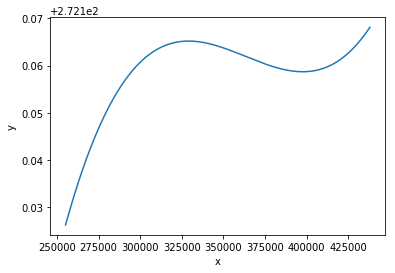

In [83]:
#plt.plot(control_cube.coord('time').points, control_cube.data)
plt.plot(control_cube.coord('time').points, cubic_fit)

plt.ylabel('y')
plt.xlabel('x')
plt.show()